In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, roc_auc_score,classification_report

#Step 1: Look at the Big Picture
##The Objective

 The goal is to build a machine learning model that predicts whether a customer will default on a loan (fail to pay it back).

###Business Value:

 By correctly identifying high-risk customers, the bank can reject their loan applications, saving money. Conversely, identifying low-risk customers allows the bank to lend more freely and earn interest.

###Type of Problem:
This is a Supervised Learning problem because we have labeled training data (we know who defaulted in the past). Specifically, it is a Binary Classification task (Target classes: $0$ for "Repaid", $1$ for "Default").

###Performance Measure :
1. **Accuracy** is rarely a good metric for credit risk because the data is usually imbalanced (e.g., 90% of people pay back loans; a model that blindly guesses "No Default" would have 90% accuracy but be useless).Instead, we focus on:

2. **Recall** (Sensitivity): Of all the actual defaulters, how many did we catch? (We want this high).Precision: Of all the people we labeled "high risk," how many actually were?ROC-AUC (Receiver Operating Characteristic - Area Under Curve): A great metric for comparing models on imbalanced data.

The Trade-off:In credit risk, a False Negative (predicting "Safe" when the customer actually Defaults) is very expensive—the bank loses the entire loan amount. A False Positive (predicting "Default" when the customer is actually Safe) only costs the bank the lost interest. Therefore, we often prioritize Recall over Precision.
  
###Assumptions:
 The historical data provided (the Kaggle dataset) is representative of future applicants.Assumption: The "features" (income, age, employment history) actually correlate with creditworthiness.

#Step 2: Get the Data
German Credit Data

In [5]:
df = pd.read_csv('../data/credit_risk_dataset.csv')

# Check the dimensions of the data
print(f"Data shape: {df.shape}")

Data shape: (32581, 12)


In [6]:
# View the first 5 rows
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


Data description of Credit Risk dataset:

Feature Name : Description

person_age : Age

person_income : Annual Income

person_home_ownership : Home ownership

person_emp_length : Employment length (in years)

loan_intent : Loan intent

loan_grade : Loan grade

loan_amnt : Loan amount

loan_int_rate : Interest rate

loan_status : Loan status (0 is non default 1 is default)

loan_percent_income : Percent income

cb_person_default_on_file : Historical default

cb_preson_cred_hist_length : Credit history length

In [7]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [8]:
#Target Column - loan_status
#Features - 'person_age', 'person_income', 'person_home_ownership','person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt','loan_int_rate', 'loan_percent_income','cb_person_default_on_file', 'cb_person_cred_hist_length'

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


#Step 3: Discover and Visualize

1. Check Class Imbalance (The Target)

In [10]:
df['loan_status'].value_counts()

loan_status
0    25473
1     7108
Name: count, dtype: int64

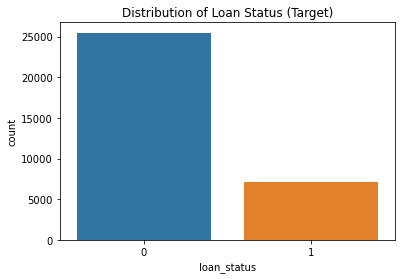

loan_status
0    78.183604
1    21.816396
Name: proportion, dtype: float64


In [11]:
# Check the ratio of defaults
sns.countplot(x='loan_status', data=df)
plt.title('Distribution of Loan Status (Target)')
plt.show()

# Print actual percentages
print(df['loan_status'].value_counts(normalize=True) * 100)

In [12]:
#moderate imbalance. therefore not usig smote

2. Visualize Numerical Distributions & Outliers

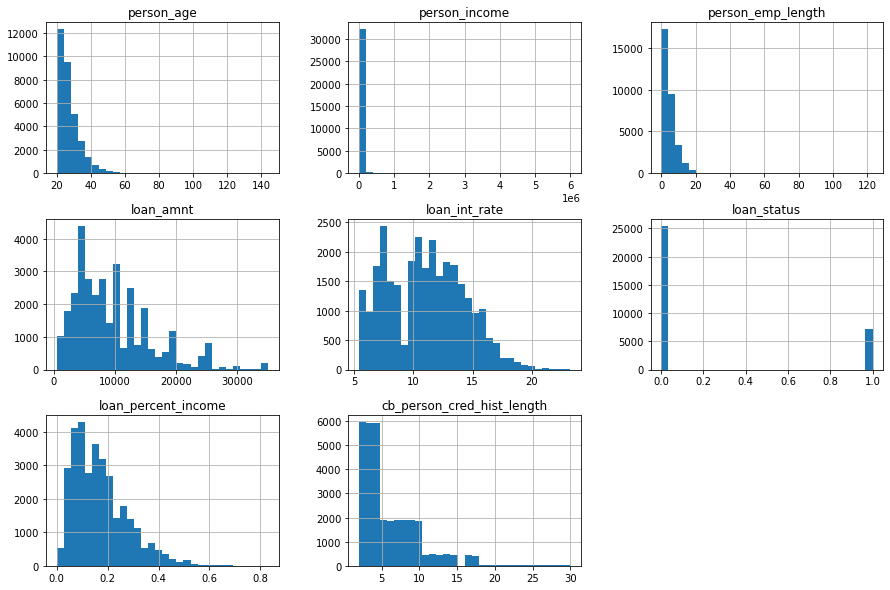

In [13]:
# Plot histograms for numeric columns
df.hist(bins=30, figsize=(15, 10))
plt.show()



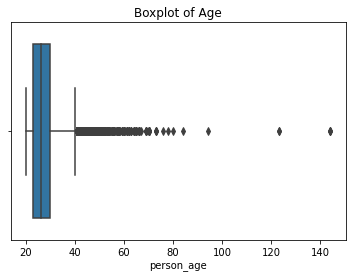

In [14]:
# Check specifically for outliers in Age (Common issue in this dataset)
sns.boxplot(x=df['person_age'])
plt.title('Boxplot of Age')
plt.show()



In [15]:
# Check the max age
print(f"Max Age: {df['person_age'].max()}")

Max Age: 144


3. Analyze Correlations

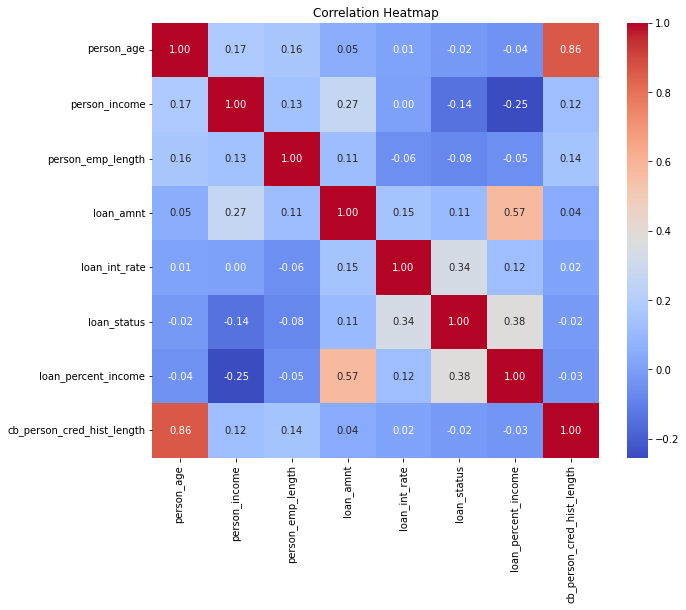

In [16]:
# Correlation matrix
corr_matrix = df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

4. Categorical Analysis

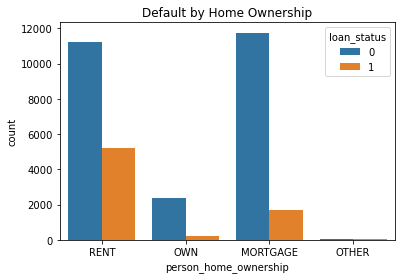

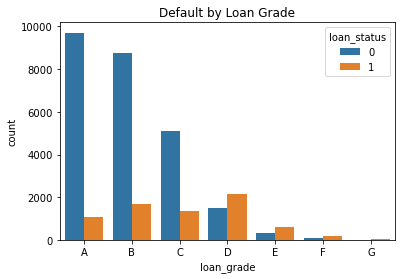

In [17]:
# Default rate by Home Ownership
sns.countplot(x='person_home_ownership', hue='loan_status', data=df)
plt.title('Default by Home Ownership')
plt.show()

# Default rate by Loan Grade
sns.countplot(x='loan_grade', hue='loan_status', data=df, order=sorted(df['loan_grade'].unique()))
plt.title('Default by Loan Grade')
plt.show()

#Step 4: Data Preparation

1. Handle Outliers (The "Age" Issue)

In [18]:
# Check how many people are over 100 years old
print(df[df['person_age'] > 100])

# Drop these records (they are likely errors)
df = df[df['person_age'] < 100]

       person_age  person_income person_home_ownership  person_emp_length  \
81            144         250000                  RENT                4.0   
183           144         200000              MORTGAGE                4.0   
575           123          80004                  RENT                2.0   
747           123          78000                  RENT                7.0   
32297         144        6000000              MORTGAGE               12.0   

      loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
81        VENTURE          C       4800          13.57            0   
183     EDUCATION          B       6000          11.86            0   
575     EDUCATION          B      20400          10.25            0   
747       VENTURE          B      20000            NaN            0   
32297    PERSONAL          C       5000          12.73            0   

       loan_percent_income cb_person_default_on_file  \
81                    0.02                         N  

2. Handle Missing Values

In [19]:
# Fill missing employment length with the median
df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)

# Fill missing interest rate with the median
df['loan_int_rate'].fillna(df['loan_int_rate'].median(), inplace=True)

# Verify no nulls remain
print(df.isnull().sum())

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


C:\Users\rohan\AppData\Local\Temp/ipykernel_4204/1287252158.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)
C:\Users\rohan\AppData\Local\Temp/ipykernel_4204/1287252158.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

3. Handle Categorical Data (Encoding)

In [20]:
# Separate numerical and categorical columns
cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Check the new shape of the dataframe
print(df.shape)

(32576, 23)


4. Addressing Multicollinearity
Observation from Heatmap: person_age and cb_person_cred_hist_length have a correlation of 0.86.

5. Split the Data (Train / Test) (Because you have an imbalanced dataset (78% vs 22%), we must use stratify=y. This ensures the Test set also has exactly 22% defaults, so we are testing on a representative sample.)

In [21]:
# Define X (features) and y (target)
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Split 80% Train, 20% Test
# random_state=42 ensures we get the same split every time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Test shapes: X={X_test.shape}, y={y_test.shape}")

Training shapes: X=(26060, 22), y=(26060,)
Test shapes: X=(6516, 22), y=(6516,)


#Step 5: Select a model and train it.

In this step, we will train two different models to see which one performs better "out of the box."

Logistic Regression: A simple, interpretable baseline. If this works well, we don't need complex models.

Random Forest Classifier: A powerful "ensemble" model that usually performs better on credit data because it can capture complex, non-linear relationships (e.g., "High income is good, UNLESS the debt is also massive").

In [22]:
# --- Configuration ---
# Initialize both models
log_reg = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Initialize K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store scores
lr_recall, lr_auc = [], []
rf_recall, rf_auc = [], []

print("--- Starting Stratified K-Fold CV (Training Set) ---")

# Reset indices to ensure safe splitting
X_t = X_train.reset_index(drop=True)
y_t = y_train.reset_index(drop=True)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_t, y_t)):
    # Create fold data
    X_f_train, X_f_val = X_t.iloc[train_idx], X_t.iloc[val_idx]
    y_f_train, y_f_val = y_t.iloc[train_idx], y_t.iloc[val_idx]

    # --- Train & Validate Logistic Regression ---
    log_reg.fit(X_f_train, y_f_train)
    lr_pred = log_reg.predict(X_f_val)
    lr_prob = log_reg.predict_proba(X_f_val)[:, 1]

    lr_recall.append(recall_score(y_f_val, lr_pred))
    lr_auc.append(roc_auc_score(y_f_val, lr_prob))

    # --- Train & Validate Random Forest ---
    rf_model.fit(X_f_train, y_f_train)
    rf_pred = rf_model.predict(X_f_val)
    rf_prob = rf_model.predict_proba(X_f_val)[:, 1]

    rf_recall.append(recall_score(y_f_val, rf_pred))
    rf_auc.append(roc_auc_score(y_f_val, rf_prob))

    print(f"Fold {fold+1} Completed.")

# --- Summary ---
print("\n--- Logistic Regression Average ---")
print(f"Mean Recall: {np.mean(lr_recall):.4f}")
print(f"Mean AUC:    {np.mean(lr_auc):.4f}")

print("\n--- Random Forest Average ---")
print(f"Mean Recall: {np.mean(rf_recall):.4f}")
print(f"Mean AUC:    {np.mean(rf_auc):.4f}")

--- Starting Stratified K-Fold CV (Training Set) ---
Fold 1 Completed.
Fold 2 Completed.
Fold 3 Completed.
Fold 4 Completed.
Fold 5 Completed.

--- Logistic Regression Average ---
Mean Recall: 0.7738
Mean AUC:    0.8142

--- Random Forest Average ---
Mean Recall: 0.7102
Mean AUC:    0.9295


2. Preliminary Evaluation

In [23]:
print("--- Training Final Models on Full X_train ---")

# 1. Retrain Logistic Regression on full training set
final_lr = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)
final_lr.fit(X_train, y_train)

# 2. Retrain Random Forest on full training set
final_rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
final_rf.fit(X_train, y_train)

# --- Final Evaluation Function ---
def print_final_report(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n=== {name} FINAL TEST REPORT ===")
    print(classification_report(y_test, y_pred))
    print(f"Final ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")

# Run evaluation
print_final_report(final_lr, X_test, y_test, "Logistic Regression")
print_final_report(final_rf, X_test, y_test, "Random Forest")

--- Training Final Models on Full X_train ---

=== Logistic Regression FINAL TEST REPORT ===
              precision    recall  f1-score   support

           0       0.92      0.68      0.78      5094
           1       0.41      0.78      0.54      1422

    accuracy                           0.71      6516
   macro avg       0.66      0.73      0.66      6516
weighted avg       0.81      0.71      0.73      6516

Final ROC-AUC: 0.8106

=== Random Forest FINAL TEST REPORT ===
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5094
           1       0.96      0.71      0.82      1422

    accuracy                           0.93      6516
   macro avg       0.95      0.85      0.89      6516
weighted avg       0.93      0.93      0.93      6516

Final ROC-AUC: 0.9285


Logistic Regression:

Good Recall (78%): It caught most of the bad loans.

Bad Precision (41%): It wrongly accused way too many innocent people (59% false alarms). This is risky for business relationships.

Random Forest:

Excellent Overall (AUC 0.93): It is a much smarter model.

Lower Recall (71%): It played it "too safe." It missed about 29% of the defaulters because it was trying to be highly precise (96% precision).

#Step 6: Fine-tune your model.

with GridSearchCV

In [24]:
# 1. Define the model (base)
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# 2. Define the grid of hyperparameters to test
# We keep it small here to run quickly. In real projects, you'd test more.
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

# 3. Setup the Grid Search
# scoring='recall' tells it to prioritize catching defaulters!
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='recall')

Run the Search

In [25]:
# Train the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters found: {best_params}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters found: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 100}


In [26]:
#In simple terms, class_weight tells the model which mistakes are "expensive" and which are "cheap."

#By default, a Random Forest treats every row of data equally. If it misclassifies a "Safe" customer, it loses 1 point. If it misclassifies a "Defaulter," it also loses 1 point.

#In your dataset, you have 78% Safe people and 22% Defaulters. If the model ignores the Defaulters entirely, it can still get a 78% score. This is bad for a bank.

#How class_weight='balanced' Fixes This
#When you set class_weight='balanced', you are essentially changing the scoring system of the exam the model is taking.

#he New Rule:

#Getting a "Safe" person wrong costs 1 point.

#Getting a "Defaulter" wrong costs ~3.5 points. (Because they are ~3.5x rarer).

#The Effect: The model realizes, "Whoa, if I miss a Defaulter, I get a huge penalty. I better pay extra attention to them."

Evaluate the "Best" Model

In [27]:
#storing the best model
best_rf = grid_search.best_estimator_

#Evaluate on test set
y_pred_tuned = best_rf.predict(X_test)

print("--- Tuned Random Forest Report ---")
print(classification_report(y_test, y_pred_tuned))
print(f"New ROC-AUC Score: {roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1]):.4f}")

--- Tuned Random Forest Report ---
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      5094
           1       0.78      0.76      0.77      1422

    accuracy                           0.90      6516
   macro avg       0.86      0.85      0.85      6516
weighted avg       0.90      0.90      0.90      6516

New ROC-AUC Score: 0.9214


Why did Accuracy Fall?
1. The Precision-Recall "Seesaw"
Imagine the model has a "risk threshold."

Previous Model: Had a high threshold. It only cried "Default!" when it was 99% sure. It was very precise (96%) but missed some subtle defaulters (Recall 71%).

Tuned Model: You forced it to be more aggressive to catch more defaulters. It lowered its threshold.

The Gain: It caught 5% more defaulters (Recall went from 0.71 -> 0.76).

The Cost: By being aggressive, it accidentally flagged more safe people as risky (Precision dropped from 0.96 -> 0.78).

2. The Math of Imbalance
Because "Safe" loans (Class 0) make up 78% of your data, accuracy is dominated by how well you predict Class 0.

Previous Model: Correctly identified 99% of safe people.

Tuned Model: Correctly identified only 94% of safe people.

Because there are thousands of safe people, that 5% drop in Class 0 performance drags down the total accuracy score significantly, even though Class 1 performance improved.

#Step 7: Feature Importance & Business Presentation

1. Extract and Visualize Feature Importance

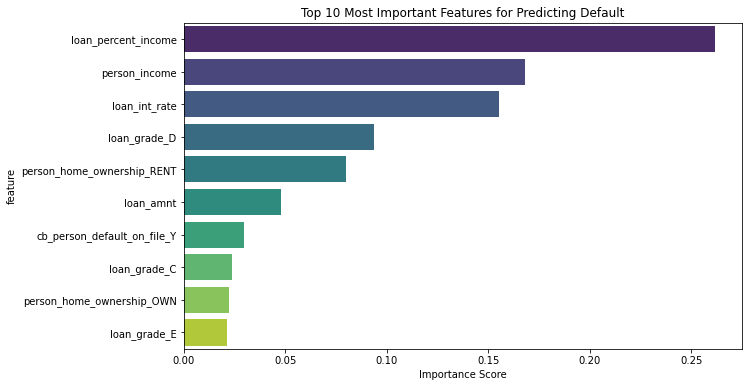

In [28]:
# Get feature importances from the best model
importances = best_rf.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

# Sort by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plot the Top 10 Features
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10), palette='viridis')
plt.title('Top 10 Most Important Features for Predicting Default')
plt.xlabel('Importance Score')
plt.show()

#Feature Importance
loan_percent_income: This is often the #1 predictor. If someone borrows 50% of their annual income, they are very risky, regardless of how rich they are.

person_income: Usually in the top 3. Lower income generally increases risk.

loan_int_rate: Banks assign higher rates to riskier people, so the model learns that "High Rate = High Risk."

person_home_ownership_RENT: Renters often default more than homeowners (who have an asset).

#Business Translation

When presenting this to stakeholders (non-coders), do not talk about "Hyperparameters" or "F1-Scores." Talk about Risk and Money.

Our model is 90% accurate overall, but more importantly, it catches 76% of all potential defaults.

Key Drivers of Risk:

Debt-to-Income Ratio: Customers borrowing more than 30% of their income are our highest risk segment.

Interest Rate: High-interest loans are defaulting frequently; we may need to review our pricing strategy for Grade D and E loans.

Housing Status: Renters are 2x more likely to default than Homeowners.

Recommendation: We should use this model to automatically flag high-risk applications for manual review, specifically focusing on loans that exceed 30% of the applicant's income.

#Conclusion
The Random Forest model achieved a Recall of 76%, effectively catching high-risk applicants.

The loan_percent_income ratio is the strongest predictor of default. The bank should strictly monitor applicants borrowing >30% of their income.